In [1]:
import sys
sys.path.append('../../')

In [2]:
from pathlib import Path
import functools
import random


from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from sklearn import metrics
from dependency_injector import providers, containers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from PIL import Image

import legoloop as ll

# Snippets

## data

In [3]:
MNIST('data', download=True, train=True);
MNIST('data', download=True, train=False);

In [4]:
def on_image(method):
    
    @functools.wraps(method)
    def real_method(sample):
        sample['image'] = method(sample['image'])
        return sample
        
    return real_method

def with_proba(proba, method):
    @functools.wraps(method)
    def real_method(sample):
        if random.uniform(0, 1) < proba:
            return method(sample)
        return sample
    return real_method

In [5]:
def float_image(image):
    return image.float() / 255 - 0.5

def transpose(image):
    return image.T

In [6]:
real_aug = transforms.Compose([
    on_image(float_image)
])
train_aug = transforms.Compose([
    on_image(float_image),
    with_proba(0.5, on_image(transpose))
])

In [7]:
class MNISTData(ll.SizedDataset):
    def __init__(self, folder, train, aug):
        self.data = MNIST(folder, download=False, train=train)
        self.aug = aug

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        res = {
            'idx': item,
            'image': self.data.data[item],
            'target': self.data.targets[item],
        }
        return self.aug(res)

MNISTData('data', True, train_aug)[10].keys()

dict_keys(['idx', 'image', 'target'])

## model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 1 -> 32 каналов
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 28x28 -> 14x14
            nn.Conv2d(32, 64, 3, padding=1), # 32 -> 64 каналов
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # 64x7x7 -> 3136
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, batch):
        feat = self.features(batch['image'].unsqueeze(1))
        logits= self.classifier(feat)
        return {
            'logits': logits,
            'probas': nn.Softmax(dim=1)(logits)
        }

## Loss & Metrics

In [9]:
class Loss(nn.Module):
    def forward(self, batch, model_out):
        return nn.CrossEntropyLoss()(
            model_out['logits'], batch['target'],
        )

In [10]:
def mnist_metrics(acc):
    logits = acc['logits']
    y_true = acc['target']
    y_pred = np.argmax(logits, axis=1)
    return {
        'accuracy': metrics.accuracy_score(y_pred, y_true) 
    }

# All Togather

## main defs

In [11]:
class MnistDefs(containers.DeclarativeContainer):
    config = providers.Configuration()
    config.from_dict({
        'loaders': {'default': {'batch_size': 256}},
        'lr': 0.001,
        'num_epochs': 8,
        'epoch_size': 60000,
        'eval_samples': 10000
    })
    data_folder = providers.Object('data')
    data = providers.Container(
        ll.Data,
        datasets=providers.Dict(
            train=providers.Singleton(MNISTData, data_folder, train=True, aug=train_aug),
            val=providers.Singleton(MNISTData, data_folder, train=False, aug=train_aug),
            val_real=providers.Singleton(MNISTData, data_folder, train=False, aug=real_aug)
        )
    )
    model = providers.Singleton(SimpleCNN)
    opt = providers.Singleton(
        lambda model, lr: optim.Adam(model.parameters(), lr=lr),
        model, config.lr
    )
    loss = providers.Singleton(Loss)
    metrics = providers.Object(mnist_metrics)

## boilerplate code

In [12]:
class MnistApp(containers.DeclarativeContainer):
    root = providers.Singleton(Path, 'learn')
    defs = providers.Container(MnistDefs)
    counter = providers.Singleton(ll.Counter)
    device = providers.Object('cuda' if torch.cuda.is_available() else 'cpu')
    feed = providers.Singleton(ll.Feed, model=defs.model, device=device)
    descent = providers.Singleton(
        ll.GradientDescent,
        opt=defs.opt, model=defs.model, feed=feed, loss=defs.loss
    )
    epoch = providers.Singleton(
        ll.SimpleEpoch,
        train_iterator=defs.data.loop_iters.provided['train'],
        epoch_size=defs.config.epoch_size
    )
    last = providers.Singleton(ll.LastEpoch, counter, defs.config.num_epochs)
    accum = providers.Factory(
        ll.CompositeAccumulator,
        logits=providers.Factory(ll.NumpyAccumulator),
        target=providers.Factory(ll.NumpyAccumulator),
        idx=providers.Factory(ll.NumpyAccumulator)
    )
    loops_acc = providers.Singleton(
        ll.LoopsAcc,
        loop_iters=defs.data.loop_iters,
        model=defs.model, factory=accum.provider,
        batch_desc=providers.Singleton(ll.DefaultBatchDesc),
        samples_limit=defs.config.eval_samples,
        feed = feed
    )
    loaders_acc = providers.Singleton(
        ll.LoadersAcc,
        loaders=defs.data.loaders,
        model=defs.model, factory=accum.provider,
        batch_desc=providers.Singleton(ll.DefaultBatchDesc),
        feed = feed
    )
    loaders_metrics = providers.Singleton(
        ll.AccumulatorMetrics,
        acc_plugin=loaders_acc,
        method=defs.metrics
    )
    loops_metrics = providers.Singleton(
        ll.AccumulatorMetrics, acc_plugin=loops_acc, method=defs.metrics
    )
    predicts = providers.Singleton(
        ll.CsvLogits,
        path=root.provided.joinpath.call('predicts.csv'),
        acc_plugin=loaders_acc,
        names=[f'logit{num}' for num in range(10)],
        acc_key='val_real',
        index='idx'
    )
    board = providers.Singleton(
        ll.TensorBoard,
        counter=counter,
        acc_metrics=loops_metrics,
        logs_dir=root.provided.joinpath.call('logs')
    )
    model_weights = providers.Singleton(
        ll.SaveModelWeights,
        defs.model,
        root.provided.joinpath.call('weights')
    )

    host = providers.Singleton(
        ll.TrainingHost, plugins=providers.List(
            counter, epoch, descent, last, 
            loops_acc, loops_metrics,
            loaders_acc, loaders_metrics,
            predicts,
            board,
            predicts,
            model_weights        
        )
    )

## run

In [13]:
%%time
app = MnistApp()
# for debug 
#app.defs.config.from_dict({'num_epochs': 1, 'epoch_size': 6000, 'eval_samples': 1000})
app.host().run()

CPU times: user 5min, sys: 2.83 s, total: 5min 3s
Wall time: 5min 3s


In [14]:
app.loaders_metrics().metrics

{'train': {'accuracy': 0.9909833333333333},
 'val': {'accuracy': 0.9802},
 'val_real': {'accuracy': 0.9784}}

# Predictions

In [15]:
preds = pd.read_csv(app.root()/'predicts.csv', index_col=0).idxmax(axis=1)
preds = preds.str.replace('logit','').astype(int).sort_index()
preds.sample(3)

idx
9599    1
4780    0
2460    5
dtype: int64

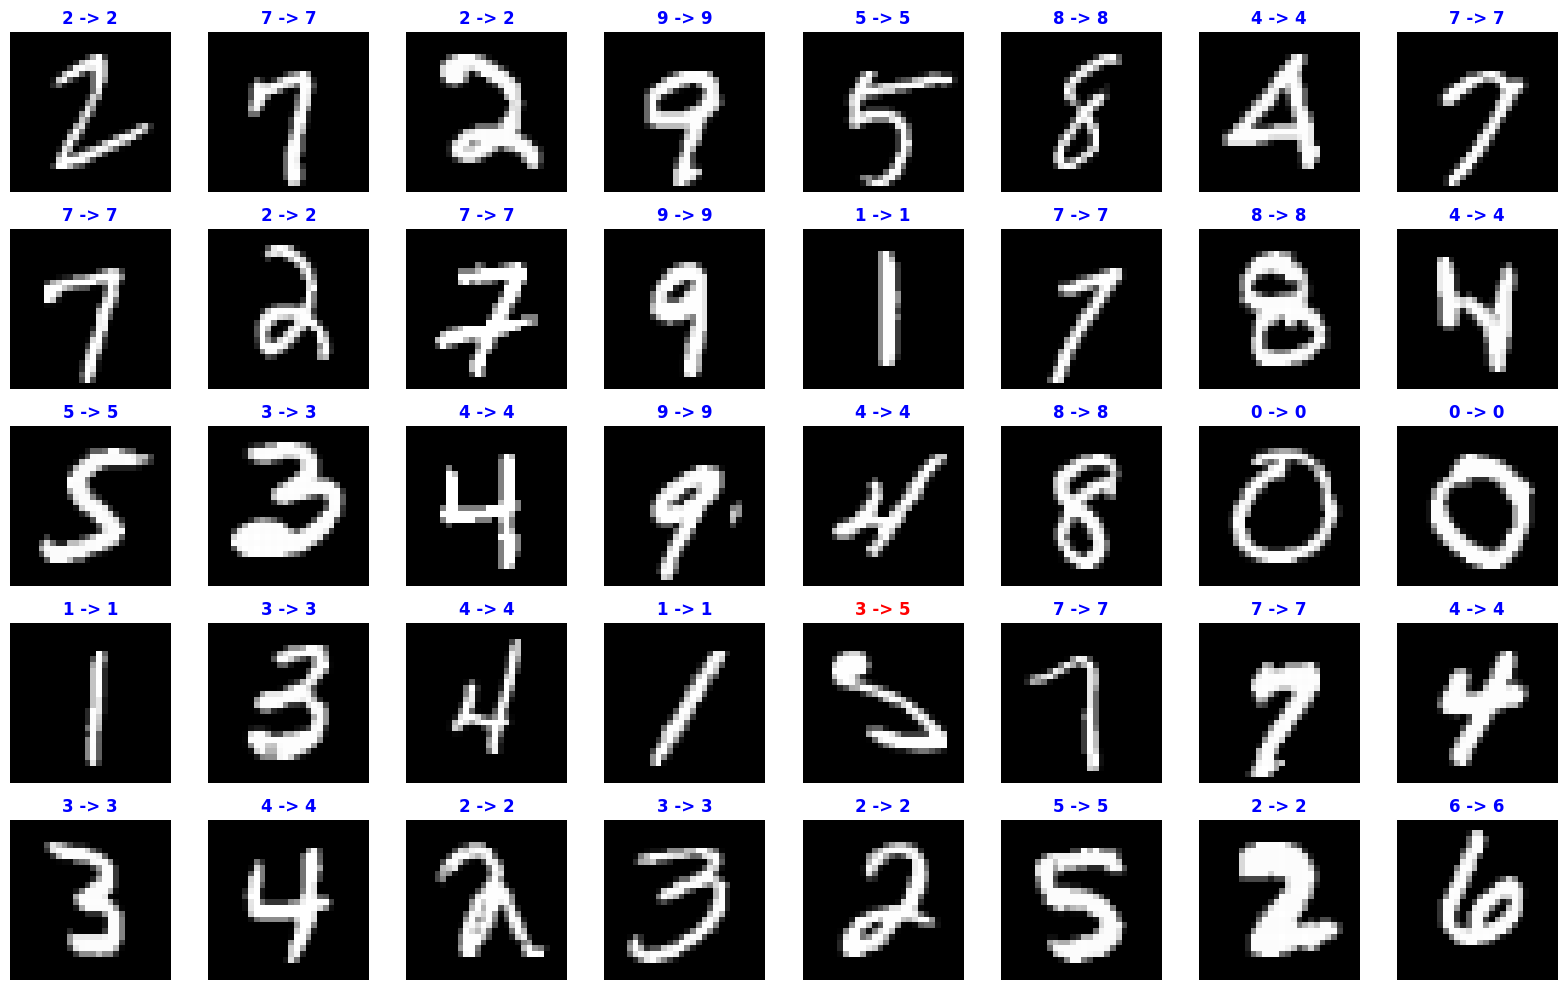

In [16]:
def plot_predictions(dataset, preds, rows=5, columns=8):
    fig, axes = plt.subplots(rows, columns, figsize=(2*columns, 2*rows))
    axes = axes.ravel()
    sel = np.random.choice(preds.index, size=rows * columns, replace=False)
    
    for i, idx in enumerate(sel):
        sample = dataset[idx]
        axes[i].imshow(dataset[idx]['image'], cmap='gray')
        axes[i].axis('off')
        
        # Подсветка ошибок красным цветом
        if sample['target'] != preds.loc[idx]:
            axes[i].set_title(
                f"{preds.loc[idx]} -> {sample['target']}", color='red', fontweight='bold'
            )
        else:
             axes[i].set_title(
                f"{preds.loc[idx]} -> {sample['target']}", color='blue', fontweight='bold'
            )
    
    plt.tight_layout()
    plt.show()

plot_predictions(
    app.defs.data.datasets()['val_real'], preds
)